# ElasticNet Regression for Porsche Listings

This notebook performs ElasticNet regression (with cross-validation) on the Porsche listings dataset, following the same workflow as the Ridge regression notebook.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns

import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler

In [2]:
file_path = '../data/all_listings_gold.xlsx'

In [3]:
# --- Step 1: Define your features ---
numeric_cols = ['Mileage_sq', 'log_mileage']
categorical_cols = [
    'series_911 F-Model', 'series_911 G-Model', 'series_912', 'series_991', 'series_992',
    'series_993', 'series_996', 'series_997', 'model_Carrera 3.0/3.2 / S / SC',
    'model_GT2RS and RARE Models', 'model_GT3 / GT2', 'model_GT3RS', 'model_RS Model',
    'model_Special / Backdate', 'model_Turbo S / Turbo', 'state_yes', 'state_Manual',
    'state_PDK', 'state_Rear drive', 'matching_yes', 'car_location_United States',
    'is_fully_restored', 'Paint-to-Sample (PTS)', 'listing_score'
]

interaction_cols = [
# 'model_RS_series_964', 'model_Turbo_series_930'
#'age_KM'
]

In [4]:
# Load data
df = pd.read_excel(file_path)
df = df.dropna(subset=['price_in_eur'])

X = df[numeric_cols + categorical_cols + interaction_cols].copy()
X = sm.add_constant(X)
y = df['price_in_eur']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Prepare data (already loaded and cleaned)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ElasticNet regression with cross-validation for alpha and l1_ratio
alphas = np.logspace(-4, 0, 100)
l1_ratios = np.linspace(0.05, 0.95, 10)
elasticnet = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=5, max_iter=10000)
elasticnet.fit(X_train_scaled, np.log(y_train))

# Predict log-prices and convert back to price
y_pred_log = elasticnet.predict(X_test_scaled)
y_pred = np.exp(y_pred_log)

# Calculate residuals and prediction intervals
residuals_log = np.log(y_test) - y_pred_log
residual_std = residuals_log.std()
ci = 1.645  # 90% CI (one-sided)

# Lower and upper bounds in log space
pred_lower_log = y_pred_log - ci * residual_std
pred_upper_log = y_pred_log + ci * residual_std

# Convert back to price
pred_lower = np.exp(pred_lower_log)
pred_upper = np.exp(pred_upper_log)

# Results DataFrame
results_df_enet = X_test.copy()
results_df_enet["true_price"] = y_test
results_df_enet["pred_price"] = y_pred
results_df_enet["pred_lower"] = pred_lower
results_df_enet["pred_upper"] = pred_upper
results_df_enet["true_log_price"] = np.log(y_test)
results_df_enet["pred_log_price"] = y_pred_log
results_df_enet["pred_lower_log"] = pred_lower_log
results_df_enet["pred_upper_log"] = pred_upper_log
results_df_enet["diff_price"] = y_test - y_pred

# Merge all results with original details
full_details_enet = df.loc[results_df_enet.index]
all_results_df_enet = pd.concat([full_details_enet, results_df_enet.drop(columns=X_test.columns)], axis=1)

# Filter for underpriced listings (true price below lower CI)
underpriced_df_enet = results_df_enet[
    (results_df_enet["true_log_price"] < results_df_enet["pred_log_price"]) &
    (results_df_enet["true_log_price"] < results_df_enet["pred_lower_log"])
]
underpriced_details_enet = df.loc[underpriced_df_enet.index]
underpriced_results_df_enet = pd.concat([underpriced_details_enet, underpriced_df_enet.drop(columns=X_test.columns)], axis=1)

# Write both to Excel (each as a separate sheet)
#with pd.ExcelWriter("../results/listings_elasticnet_regression_results.xlsx") as writer:
#    all_results_df_enet.to_excel(writer, sheet_name="all_results", index=False)
#    underpriced_results_df_enet.to_excel(writer, sheet_name="underpriced", index=False)

print("✅ Exported all results and underpriced listings (elasticnet regression) to listings_elasticnet_regression_results.xlsx")
print(f"Best alpha (elasticnet): {elasticnet.alpha_}")
print(f"Best l1_ratio (elasticnet): {elasticnet.l1_ratio_}")
print(f"Test R² (elasticnet, log-space): {r2_score(np.log(y_test), y_pred_log):.4f}")

✅ Exported all results and underpriced listings (elasticnet regression) to listings_elasticnet_regression_results.xlsx
Best alpha (elasticnet): 0.0007054802310718645
Best l1_ratio (elasticnet): 0.05
Test R² (elasticnet, log-space): 0.7566


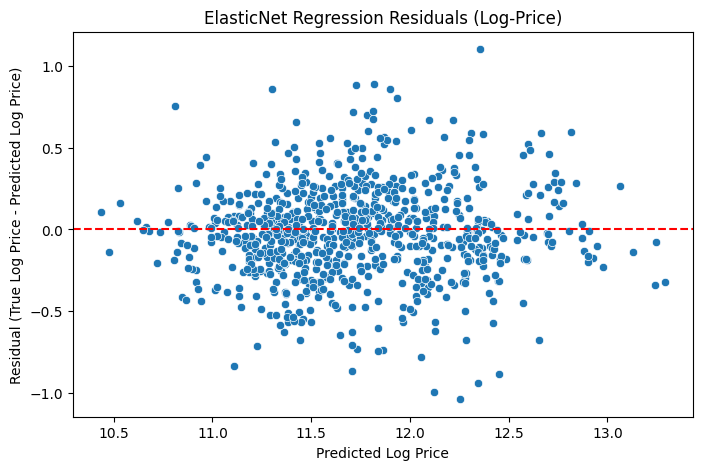

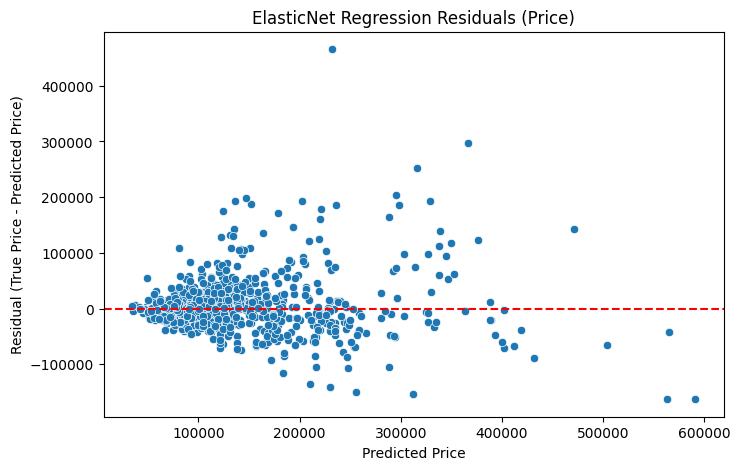

In [6]:
# Scatterplot of residuals (log-space)
plt.figure(figsize=(8, 5))
sns.scatterplot(x=results_df_enet["pred_log_price"], y=results_df_enet["true_log_price"] - results_df_enet["pred_log_price"])
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Log Price")
plt.ylabel("Residual (True Log Price - Predicted Log Price)")
plt.title("ElasticNet Regression Residuals (Log-Price)")
plt.show()

# Scatterplot of residuals (price-space)
plt.figure(figsize=(8, 5))
sns.scatterplot(x=results_df_enet["pred_price"], y=results_df_enet["true_price"] - results_df_enet["pred_price"])
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Price")
plt.ylabel("Residual (True Price - Predicted Price)")
plt.title("ElasticNet Regression Residuals (Price)")
plt.show()

In [7]:
# Exclude outliers based on price (e.g., outside 1st and 99th percentiles)
lower, upper = y.quantile(0.01), y.quantile(0.99)
mask = (y >= lower) & (y <= upper)
df_no_outliers = df[mask]
y_no_outliers = y[mask]

X_no_outliers = df_no_outliers[numeric_cols + categorical_cols + interaction_cols].copy()
X_no_outliers = sm.add_constant(X_no_outliers)

# Train/test split
X_train_no, X_test_no, y_train_no, y_test_no = train_test_split(
    X_no_outliers, y_no_outliers, test_size=0.2, random_state=42
)

# Scale features
scaler_no = StandardScaler()
X_train_no_scaled = scaler_no.fit_transform(X_train_no)
X_test_no_scaled = scaler_no.transform(X_test_no)

# ElasticNet regression with cross-validation
elasticnet_no = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=5, max_iter=10000)
elasticnet_no.fit(X_train_no_scaled, np.log(y_train_no))

# Predict log-prices and convert back to price
y_pred_no_log = elasticnet_no.predict(X_test_no_scaled)
y_pred_no = np.exp(y_pred_no_log)

print(f"Best alpha (no outliers): {elasticnet_no.alpha_}")
print(f"Best l1_ratio (no outliers): {elasticnet_no.l1_ratio_}")
print(f"Test R² (no outliers, log-space): {r2_score(np.log(y_test_no), y_pred_no_log):.4f}")

Best alpha (no outliers): 0.0016297508346206436
Best l1_ratio (no outliers): 0.05
Test R² (no outliers, log-space): 0.7539
